In [7]:
import pandas as pd

# Step 1: Load the data
file_path = 'Online Retail.xlsx'

# Load the data using pandas
df = pd.read_excel(file_path)

# Step 2: Basic Data Exploration

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Get a summary of the dataset
print("\nDataset Information:")
print(df.info())  # This will show column types and missing values

# Get descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe())

First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null C

In [9]:
# Data Cleaning

# Step 1: Handle Missing Values
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID
df['Description'] = df['Description'].fillna('Unknown')  # Fill missing Description with 'Unknown'

# Step 2: Handle Negative Values
df = df[df['Quantity'] > 0]  # Remove rows with negative Quantity
df = df[df['UnitPrice'] > 0]  # Remove rows with negative UnitPrice

# Step 3: Remove Duplicate Rows
df = df.drop_duplicates()

# Step 4: Convert Data Types
df['CustomerID'] = df['CustomerID'].astype(int)  # Convert CustomerID to integer

# Step 5: Feature Engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display cleaned data summary
print("Cleaned Dataset Information:")
print(df.info())
print("\nDescriptive Statistics After Cleaning:")
print(df.describe())

Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 28.5+ MB
None

Descriptive Statistics After Cleaning:
            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:

In [11]:
# Outlier Analysis

# Identify the top 1% of records for Quantity, UnitPrice, and TotalPrice
q_upper_limit = df['Quantity'].quantile(0.99)
up_upper_limit = df['UnitPrice'].quantile(0.99)
tp_upper_limit = df['TotalPrice'].quantile(0.99)

# Filter out the top 1% values for examination
quantity_outliers = df[df['Quantity'] > q_upper_limit]
unitprice_outliers = df[df['UnitPrice'] > up_upper_limit]
totalprice_outliers = df[df['TotalPrice'] > tp_upper_limit]

# Print a sample of these outliers for inspection
print("Quantity Outliers:")
print(quantity_outliers.head())

print("\nUnit Price Outliers:")
print(unitprice_outliers.head())

print("\nTotal Price Outliers:")
print(totalprice_outliers.head())

Quantity Outliers:
    InvoiceNo StockCode                     Description  Quantity  \
178    536387     79321                   CHILLI LIGHTS       192   
179    536387     22780  LIGHT GARLAND BUTTERFILES PINK       192   
180    536387     22779      WOODEN OWLS LIGHT GARLAND        192   
181    536387     22466   FAIRY TALE COTTAGE NIGHTLIGHT       432   
182    536387     21731   RED TOADSTOOL LED NIGHT LIGHT       432   

            InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
178 2010-12-01 09:58:00       3.82       16029  United Kingdom      733.44  
179 2010-12-01 09:58:00       3.37       16029  United Kingdom      647.04  
180 2010-12-01 09:58:00       3.37       16029  United Kingdom      647.04  
181 2010-12-01 09:58:00       1.45       16029  United Kingdom      626.40  
182 2010-12-01 09:58:00       1.25       16029  United Kingdom      540.00  

Unit Price Outliers:
    InvoiceNo StockCode                         Description  Quantity  \
45     53

In [13]:
# Date Features

# Extracting additional features from InvoiceDate
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

In [15]:
# RFM Features
# If predicting customer lifetime value, consider calculating Recency, Frequency, and Monetary value (RFM) for each customer.

# Feature Engineering for RFM Analysis
import datetime

# Assume the latest date in the dataset to be the reference date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create Recency, Frequency, and Monetary value per customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (Number of invoices)
    'TotalPrice': 'sum'  # Monetary Value
}).reset_index()

# Rename columns to appropriate RFM labels
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

print("\nRFM Analysis Sample:")
print(rfm.head())


RFM Analysis Sample:
   CustomerID  Recency  Frequency  MonetaryValue
0       12346      326          1       77183.60
1       12347        2          7        4310.00
2       12348       75          4        1797.24
3       12349       19          1        1757.55
4       12350      310          1         334.40


In [17]:
# Step 3: Exploratory Data Analysis (EDA)
# Summary Statistics

# Overall Revenue
total_revenue = df['TotalPrice'].sum()
average_revenue = df['TotalPrice'].mean()

# Average Order Value (AOV)
order_value_df = df.groupby('InvoiceNo')['TotalPrice'].sum()  # Summing TotalPrice per invoice
average_order_value = order_value_df.mean()

# Number of Unique Customers
unique_customers = df['CustomerID'].nunique()

# Order Frequency per Customer
customer_order_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Display Summary Statistics
print("Summary Statistics:")
print(f"Total Revenue: {total_revenue}")
print(f"Average Revenue: {average_revenue}")
print(f"Average Order Value: {average_order_value}")
print(f"Number of Unique Customers: {unique_customers}")
print(f"Average Order Frequency per Customer: {customer_order_frequency.mean()}")

Summary Statistics:
Total Revenue: 8887208.894
Average Revenue: 22.6314997351614
Average Order Value: 479.56016047917126
Number of Unique Customers: 4338
Average Order Frequency per Customer: 4.272014753342554


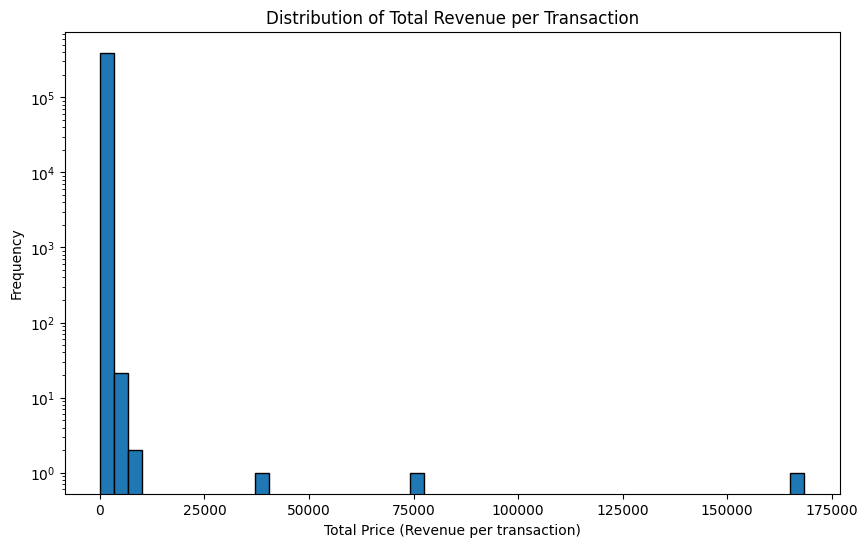

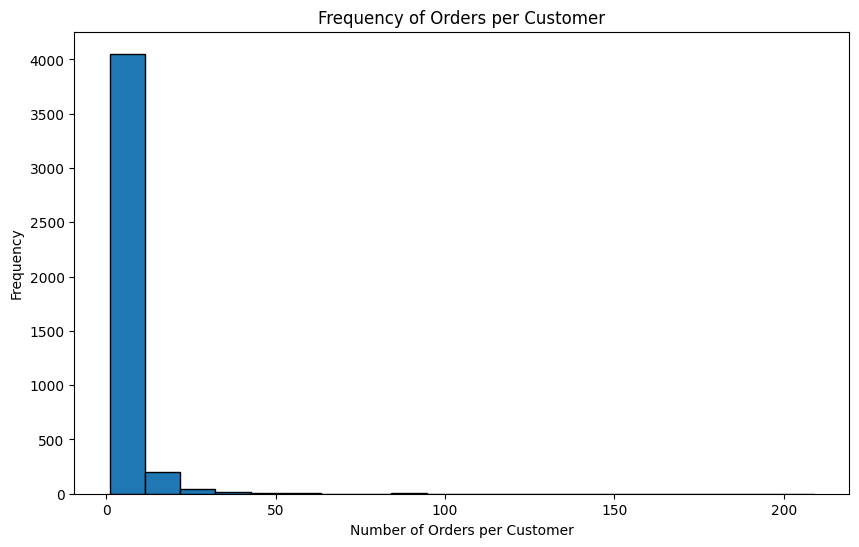

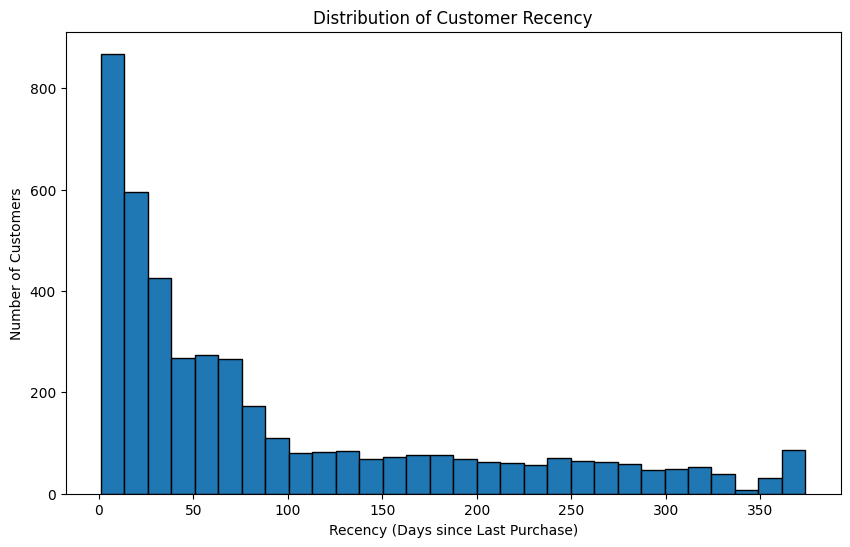

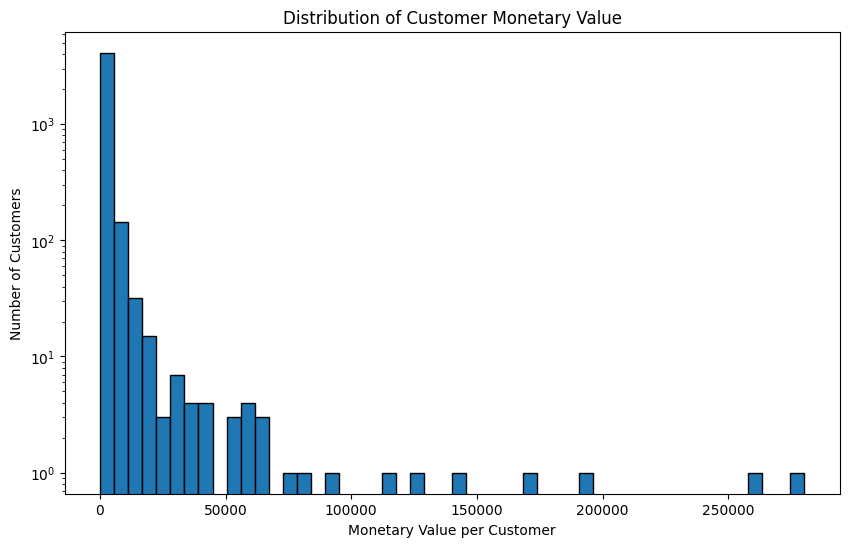

In [19]:
# Visualizations

import matplotlib.pyplot as plt

# Visualization 1: Total Revenue Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['TotalPrice'], bins=50, edgecolor='k')
plt.xlabel('Total Price (Revenue per transaction)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Revenue per Transaction')
plt.yscale('log')  # Applying log scale to handle skewness due to outliers
plt.show()

# Visualization 2: Frequency of Orders per Customer
plt.figure(figsize=(10, 6))
plt.hist(customer_order_frequency, bins=20, edgecolor='k')
plt.xlabel('Number of Orders per Customer')
plt.ylabel('Frequency')
plt.title('Frequency of Orders per Customer')
plt.show()

# Visualization 3: Recency Distribution
plt.figure(figsize=(10, 6))
plt.hist(rfm['Recency'], bins=30, edgecolor='k')
plt.xlabel('Recency (Days since Last Purchase)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Recency')
plt.show()

# Visualization 4: Monetary Value Distribution
plt.figure(figsize=(10, 6))
plt.hist(rfm['MonetaryValue'], bins=50, edgecolor='k')
plt.xlabel('Monetary Value per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Monetary Value')
plt.yscale('log')  # Applying log scale to handle skewness
plt.show()

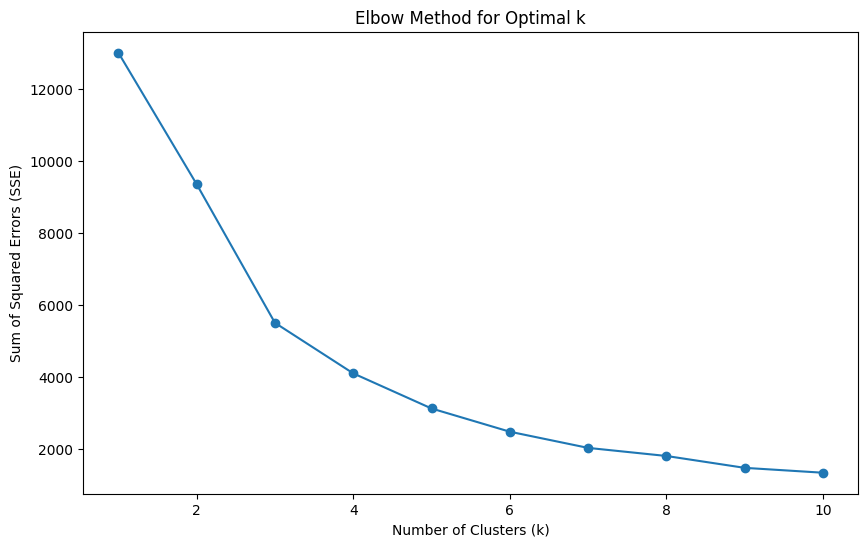

Silhouette Score for k=4: 0.6162275299061803


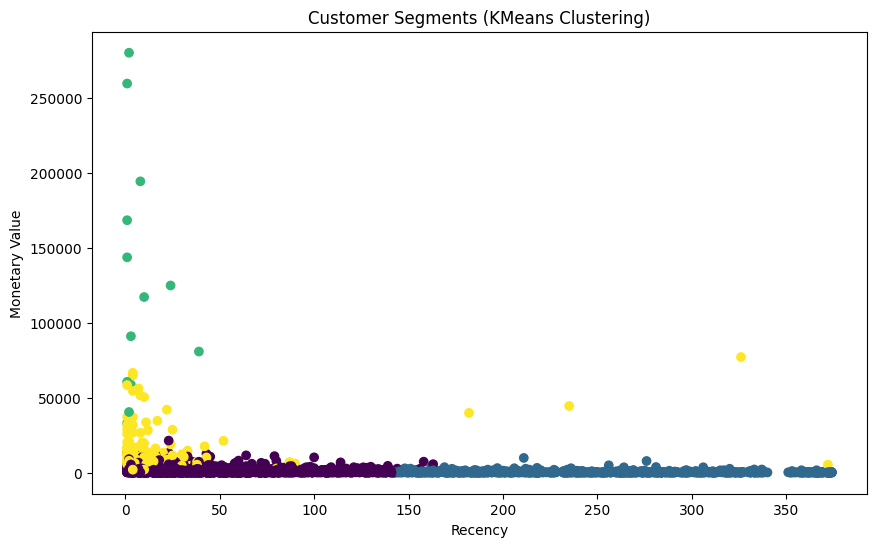

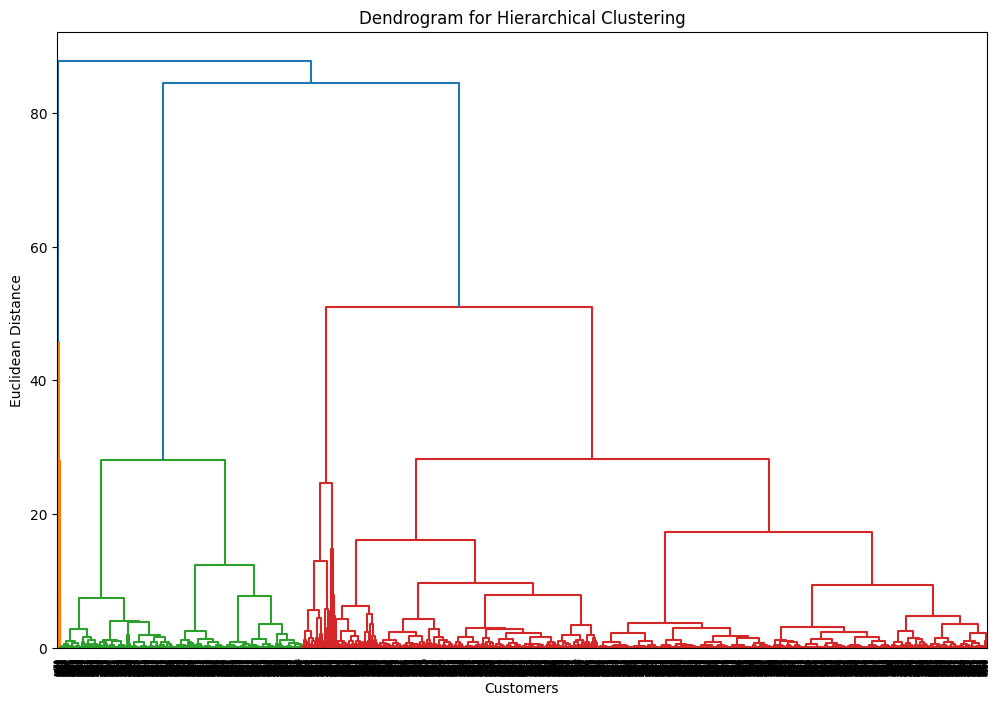

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [21]:
# Step 4: Segmentation 
# Customer Segmentation:
# Apply techniques like KMeans Clustering or Hierarchical Clustering to segment customers based on their behavior.
# This can be useful for distinguishing high-value customers from others for targeting purposes.

# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Assuming we have the RFM data computed already as "rfm"
# RFM: 'CustomerID', 'Recency', 'Frequency', 'MonetaryValue'

# Step 2: Data Normalization
# Normalizing the RFM data (excluding CustomerID)
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# Step 3: KMeans Clustering
# Using the Elbow Method to find the optimal number of clusters
sse = []  # Sum of squared errors for each k
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choosing k based on the elbow plot (e.g., k=4) and fitting KMeans
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_normalized)

# Silhouette Score
silhouette_avg = silhouette_score(rfm_normalized, rfm['KMeans_Cluster'])
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg}")

# Step 4: Visualizing KMeans Clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['MonetaryValue'], c=rfm['KMeans_Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.title('Customer Segments (KMeans Clustering)')
plt.show()

# Step 5: Hierarchical Clustering
# Using linkage for Hierarchical Clustering
linkage_matrix = linkage(rfm_normalized, method='ward')

# Plotting the Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

# Assigning Clusters using Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

# Choosing 4 clusters based on dendrogram and fitting AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
rfm['Agg_Cluster'] = agg_cluster.fit_predict(rfm_normalized)

# Step 6: Visualizing Hierarchical Clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['MonetaryValue'], c=rfm['Agg_Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.title('Customer Segments (Hierarchical Clustering)')
plt.show()

In [23]:
# Step 5: Data Transformation and Feature Engineering

# Feature Normalization/Standardization
from sklearn.preprocessing import StandardScaler

# Assuming the RFM DataFrame has the following columns: 'Recency', 'Frequency', 'MonetaryValue'

# Creating a new DataFrame to keep features after standardization
features = rfm[['Recency', 'Frequency', 'MonetaryValue']]

# Step 1: Standardizing the features using StandardScaler
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Converting the normalized features back into a DataFrame for easier manipulation and interpretation
rfm_normalized_df = pd.DataFrame(features_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
print(rfm_normalized_df.head())

    Recency  Frequency  MonetaryValue
0  2.334574  -0.425097       8.363010
1 -0.905340   0.354417       0.251699
2 -0.175360  -0.035340      -0.027988
3 -0.735345  -0.425097      -0.032406
4  2.174578  -0.425097      -0.190812


In [27]:
# Creating the Target Variable (CLV)

# Sum of Future Purchases (e.g., Over the Next Year)

import datetime

# Assume the current observation date to split training and future data
observation_date = df['InvoiceDate'].max() - pd.Timedelta(days=365)

# Split data into the training period and the future period
train_data = df[df['InvoiceDate'] <= observation_date]
future_data = df[df['InvoiceDate'] > observation_date]

# Calculate the total value for each customer during the future period
future_clv = future_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
future_clv.columns = ['CustomerID', 'Future_CLV']

# Merge future CLV with the RFM data (training features)
rfm_clv = pd.merge(rfm, future_clv, on='CustomerID', how='left')
rfm_clv['Future_CLV'].fillna(0, inplace=True)  # Customers without future purchases are filled with 0
print(rfm_clv.head())

   CustomerID  Recency  Frequency  MonetaryValue  KMeans_Cluster  Future_CLV
0       12346      326          1       77183.60               3    77183.60
1       12347        2          7        4310.00               0     3598.21
2       12348       75          4        1797.24               0     1797.24
3       12349       19          1        1757.55               0     1757.55
4       12350      310          1         334.40               1      334.40


In [29]:
#  Model Selection and Training

from sklearn.model_selection import train_test_split

# Assuming rfm_clv DataFrame has the following columns: 'Recency', 'Frequency', 'MonetaryValue', 'Future_CLV'
X = rfm_clv[['Recency', 'Frequency', 'MonetaryValue']]  # Features
y = rfm_clv['Future_CLV']  # Target Variable

# Split the data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape}")
print(f"Testing Set Size: {X_test.shape}")

Training Set Size: (3470, 3)
Testing Set Size: (868, 3)


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 3.1: Define a Baseline Model - Linear Regression
linear_model = LinearRegression()

# Train the Linear Regression model
linear_model.fit(X_train, y_train)

# Evaluate the Linear Regression model using cross-validation
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
linear_rmse = np.sqrt(-linear_cv_scores.mean())
print(f"Linear Regression Cross-Validation RMSE: {linear_rmse}")

# Step 3.2: Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Random Forest Regressor
random_forest_model.fit(X_train, y_train)

# Evaluate the Random Forest Regressor using cross-validation
rf_cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(-rf_cv_scores.mean())
print(f"Random Forest Cross-Validation RMSE: {rf_rmse}")

# Step 3.3: Gradient Boosting - XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train XGBoost Regressor
xgb_model.fit(X_train, y_train)

# Evaluate the XGBoost Regressor using cross-validation
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(-xgb_cv_scores.mean())
print(f"XGBoost Cross-Validation RMSE: {xgb_rmse}")

Linear Regression Cross-Validation RMSE: 312.11071326108083
Random Forest Cross-Validation RMSE: 2317.760871443589
XGBoost Cross-Validation RMSE: 6179.5164254634


In [33]:
# Model Evaluation on the Test Set

# Function to evaluate model performance on the test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

# Evaluate Linear Regression
print("\nLinear Regression Evaluation on Test Set:")
evaluate_model(linear_model, X_test, y_test)

# Evaluate Random Forest Regressor
print("\nRandom Forest Regressor Evaluation on Test Set:")
evaluate_model(random_forest_model, X_test, y_test)

# Evaluate XGBoost Regressor
print("\nXGBoost Regressor Evaluation on Test Set:")
evaluate_model(xgb_model, X_test, y_test)


Linear Regression Evaluation on Test Set:
RMSE: 836.2576840106182
MAE: 113.94142455829396
R²: 0.9918873798909951

Random Forest Regressor Evaluation on Test Set:
RMSE: 552.2743512032955
MAE: 114.91237384792598
R²: 0.9964617326472447

XGBoost Regressor Evaluation on Test Set:
RMSE: 4271.334752146471
MAE: 339.85847348151225
R²: 0.7883549500808265


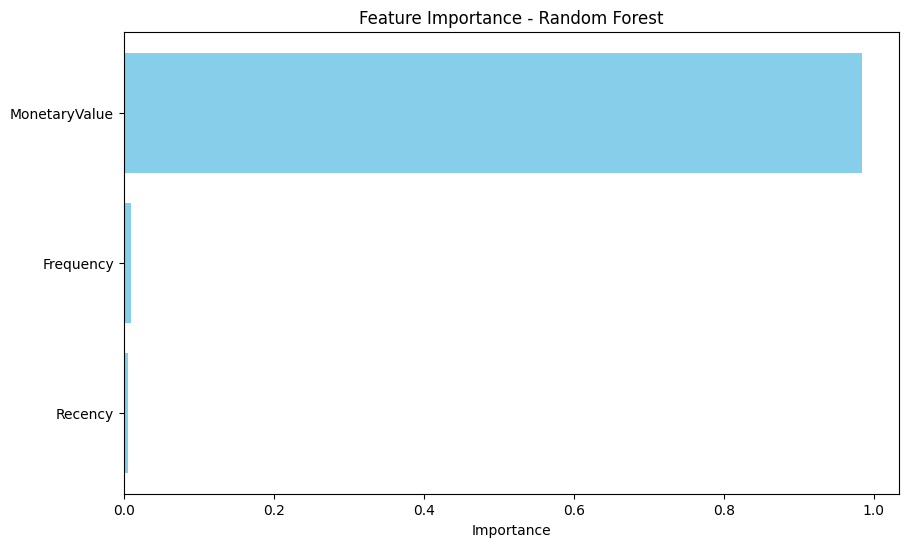

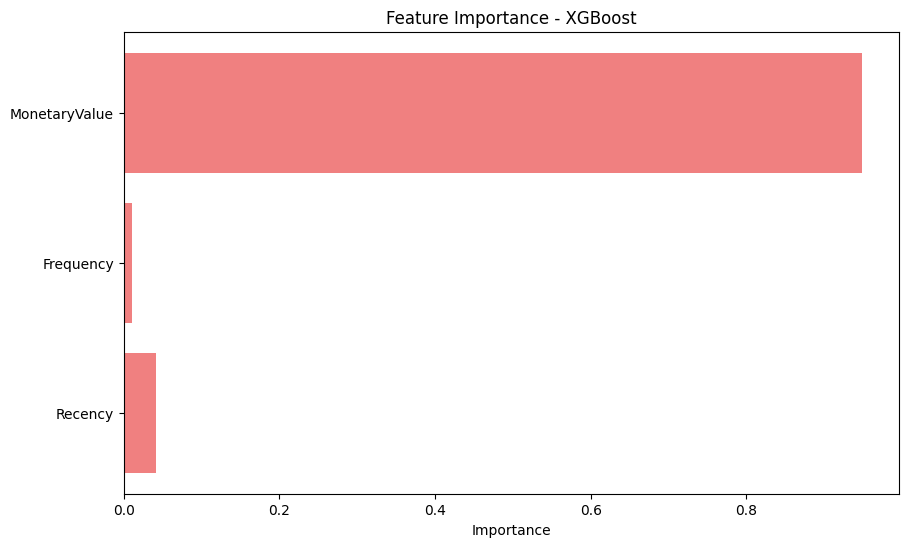

In [35]:
# Feature Importance
import matplotlib.pyplot as plt

# Random Forest Feature Importance
importances_rf = random_forest_model.feature_importances_
features_list = ['Recency', 'Frequency', 'MonetaryValue']

plt.figure(figsize=(10, 6))
plt.barh(features_list, importances_rf, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

# XGBoost Feature Importance
importances_xgb = xgb_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(features_list, importances_xgb, color='lightcoral')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.show()

In [41]:
# Hyperparameter Tuning

# Let’s start by tuning the Random Forest Regressor using GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Randomized Search Parameter Grid
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=2)

# Fit RandomizedSearch to training data
random_search_rf.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters from Randomized Search for Random Forest: ", random_search_rf.best_params_)

# Evaluate the tuned Random Forest model
best_rf_random = random_search_rf.best_estimator_
y_pred_rf_random = best_rf_random.predict(X_test)

rmse_rf_random = np.sqrt(mean_squared_error(y_test, y_pred_rf_random))
mae_rf_random = mean_absolute_error(y_test, y_pred_rf_random)
r2_rf_random = r2_score(y_test, y_pred_rf_random)

print("\nTuned Random Forest Evaluation (Randomized Search):")
print(f"RMSE: {rmse_rf_random}")
print(f"MAE: {mae_rf_random}")
print(f"R²: {r2_rf_random}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from Randomized Search for Random Forest:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

Tuned Random Forest Evaluation (Randomized Search):
RMSE: 2774.4938561270146
MAE: 444.09401782588606
R²: 0.9107006224126168


In [39]:
# For XGBoost, let’s use RandomizedSearchCV to explore a broader hyperparameter space more efficiently

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the parameter grid for RandomizedSearch
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# Initialize the XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=2)

# Fit RandomizedSearch to training data
random_search_xgb.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters for XGBoost: ", random_search_xgb.best_params_)

# Evaluate the tuned XGBoost model
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nTuned XGBoost Evaluation:")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R²: {r2_xgb}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for XGBoost:  {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}

Tuned XGBoost Evaluation:
RMSE: 4237.147755216641
MAE: 503.2624619230631
R²: 0.7917293298629897


In [43]:
# Prediction and Business Insights

# Predict CLV Using the Tuned Models

import pandas as pd

# Step 1: Predict CLV for the Customers in the Test Set
# Predict using the tuned Random Forest model
y_pred_rf_test = best_rf_random.predict(X_test)

# Predict using the tuned XGBoost model
y_pred_xgb_test = best_xgb.predict(X_test)

# Create a DataFrame to store the actual and predicted values
predictions_df = pd.DataFrame({
    'CustomerID': X_test.index,
    'Actual_CLV': y_test,
    'Predicted_CLV_RF': y_pred_rf_test,
    'Predicted_CLV_XGB': y_pred_xgb_test
})

# Display the first few rows to verify
print(predictions_df.head())

      CustomerID  Actual_CLV  Predicted_CLV_RF  Predicted_CLV_XGB
3975        3975      131.94        249.837296         378.468048
1448        1448      477.79        425.633715         658.780457
2662        2662     1054.73        851.870352        1136.297974
17            17     1313.10       1239.209353        1377.668335
1634        1634     1432.00       1282.288552        1483.621460


In [45]:
# Segment Customers Based on Predicted CLV

# Step 2: Segment Customers Based on Predicted CLV (using Random Forest predictions)

# Calculate the quantiles to determine the segments
high_threshold = predictions_df['Predicted_CLV_RF'].quantile(0.8)
medium_threshold = predictions_df['Predicted_CLV_RF'].quantile(0.6)

# Assign segment labels
def segment_customer(clv):
    if clv >= high_threshold:
        return 'High CLV'
    elif clv >= medium_threshold:
        return 'Medium CLV'
    else:
        return 'Low CLV'

# Apply segmentation to the predictions DataFrame
predictions_df['Segment'] = predictions_df['Predicted_CLV_RF'].apply(segment_customer)

# Display the number of customers in each segment
segment_counts = predictions_df['Segment'].value_counts()
print("\nCustomer Segment Counts:")
print(segment_counts)

# Preview the segmented DataFrame
print(predictions_df.head())


Customer Segment Counts:
Segment
Low CLV       521
High CLV      174
Medium CLV    173
Name: count, dtype: int64
      CustomerID  Actual_CLV  Predicted_CLV_RF  Predicted_CLV_XGB     Segment
3975        3975      131.94        249.837296         378.468048     Low CLV
1448        1448      477.79        425.633715         658.780457     Low CLV
2662        2662     1054.73        851.870352        1136.297974     Low CLV
17            17     1313.10       1239.209353        1377.668335  Medium CLV
1634        1634     1432.00       1282.288552        1483.621460  Medium CLV


In [ ]:
# High CLV: Customers in the top 20% of predicted CLV.
# Medium CLV: Customers between the 60th and 80th percentiles.
# Low CLV: Customers in the bottom 60%.

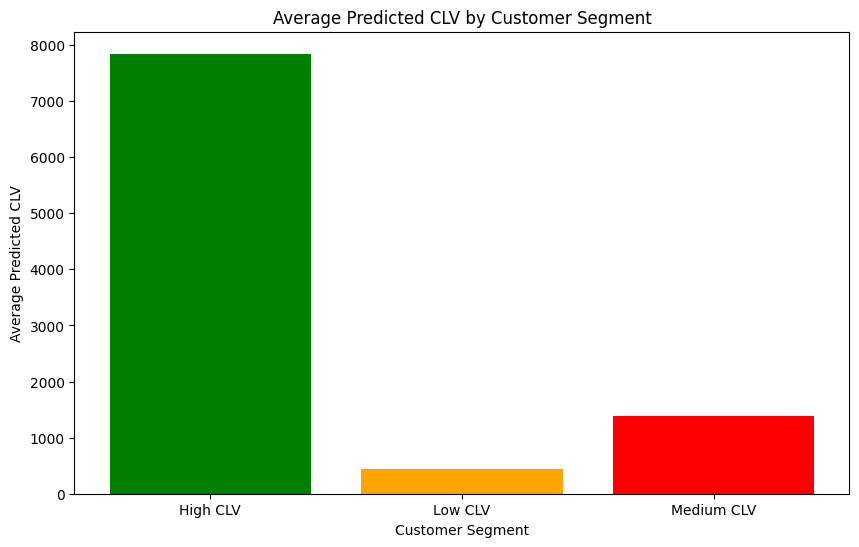

In [47]:
# Compare the Segments

import matplotlib.pyplot as plt

# Calculate the average predicted CLV for each segment
avg_clv_by_segment = predictions_df.groupby('Segment')['Predicted_CLV_RF'].mean().reset_index()

# Plotting the average CLV by segment
plt.figure(figsize=(10, 6))
plt.bar(avg_clv_by_segment['Segment'], avg_clv_by_segment['Predicted_CLV_RF'], color=['green', 'orange', 'red'])
plt.xlabel('Customer Segment')
plt.ylabel('Average Predicted CLV')
plt.title('Average Predicted CLV by Customer Segment')
plt.show()

In [ ]:
# Interpretation

# Segment Analysis:
# High CLV Segment: This group of 174 customers is expected to be the most valuable to the company. They should be targeted with retention campaigns, loyalty programs, and exclusive promotions to maximize engagement and spending.
# Medium CLV Segment: This group of 173 customers is valuable but might need further nurturing. Cross-sell or up-sell opportunities might work well for these customers to move them towards becoming high-value customers.
# Low CLV Segment: The majority of customers (521) fall into this category. Strategies for these customers may include cost-effective marketing campaigns or re-engagement tactics to increase their value. For example, discount offers or reminding them of their abandoned cart could help increase their engagement.

# Model Comparison:
# The Random Forest predictions were used for segmentation, which seems more appropriate given the lower RMSE and higher R² compared to XGBoost.
# XGBoost showed a tendency to overestimate the values, possibly due to hyperparameters such as learning rate or max depth not being fully optimized. However, Random Forest produced more stable predictions, making it more suitable for segmenting customers in this case.

# Next Actions for Marketing:
# High CLV Customers: Invest in personalized engagement, exclusive benefits, and loyalty programs.
# Medium CLV Customers: Engage with targeted promotions, cross-sell, and product recommendations.
# Low CLV Customers: Use cost-effective marketing strategies like bulk emails, discount reminders, and focus on brand awareness to retain these customers.